**[HWR-01]** 必要なモジュールをインポートします。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
### Windwos版では下記が必要
import os
###

**[HWR-02]** 1段目の畳み込みフィルターとプーリング層を定義します。

In [2]:
num_filters1 = 32

x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1,28,28,1])

W_conv1 = tf.Variable(tf.truncated_normal([5,5,1,num_filters1],
                                          stddev=0.1))
h_conv1 = tf.nn.conv2d(x_image, W_conv1,
                       strides=[1,1,1,1], padding='SAME')

b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))
h_conv1_cutoff = tf.nn.relu(h_conv1 + b_conv1)

h_pool1 =tf.nn.max_pool(h_conv1_cutoff, ksize=[1,2,2,1],
                        strides=[1,2,2,1], padding='SAME')

**[HWR-03]** 2段目の畳み込みフィルターとプーリング層を定義します。

In [3]:
num_filters2 = 64

W_conv2 = tf.Variable(
            tf.truncated_normal([5,5,num_filters1,num_filters2],
                                stddev=0.1))
h_conv2 = tf.nn.conv2d(h_pool1, W_conv2,
                       strides=[1,1,1,1], padding='SAME')

b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))
h_conv2_cutoff = tf.nn.relu(h_conv2 + b_conv2)

h_pool2 =tf.nn.max_pool(h_conv2_cutoff, ksize=[1,2,2,1],
                        strides=[1,2,2,1], padding='SAME')

**[HWR-04]** 全結合層、ドロップアウト層、ソフトマックス関数を定義します。

In [4]:
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*num_filters2])

num_units1 = 7*7*num_filters2
num_units2 = 1024

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))
hidden2 = tf.nn.relu(tf.matmul(h_pool2_flat, w2) + b2)

keep_prob = tf.placeholder(tf.float32)
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)

w0 = tf.Variable(tf.zeros([num_units2, 10]))
b0 = tf.Variable(tf.zeros([10]))
p = tf.nn.softmax(tf.matmul(hidden2_drop, w0) + b0)

**[HWR-05]** セッションを用意して Variable を初期化した後、最適化処理を実施済みのセッションを復元します。

In [5]:
### >>> with GPU 80%
#gpuConfig = tf.ConfigProto(
#    gpu_options = tf.GPUOptions(
#        per_process_gpu_memory_fraction = 0.8),
#    device_count = {'GPU':0})
#sess = tf.Session(config = gpuConfig)
### <<<
#
### >>> with CPU only
sess = tf.Session()
### <<<
sess.run(tf.global_variables_initializer())
### 下記はPython3.6ではエラーとなるので、上記に変更した。
#sess.run(tf.initialize_all_variables())
saver = tf.train.Saver()
### Windwos版では下記が必要
cwd = os.getcwd()
###
### Windwos版        
saver.restore(sess, cwd + '\\cnn_session-20000')
### Linux等、Windows以外であれば、下記行頭の「#」を外し、上記の行頭に「#」を入れる。
#saver.restore(sess, 'cnn_session-20000')

INFO:tensorflow:Restoring parameters from C:\Users\HN\Jupyter\jupyter_tfbook\Chapter05\cnn_session-20000


**[HWR-06]** 手書き文字を入力するためのJavaScriptのコードを用意します。

In [6]:
input_form = """
<table>
<td style="border-style: none;">
<div style="border: solid 2px #666; width: 143px; height: 144px;">
<canvas width="140" height="140"></canvas>
</div></td>
<td style="border-style: none;">
<button onclick="clear_value()">Clear</button>
</td>
</table>
"""

javascript = """
<script type="text/Javascript">
    var pixels = [];
    for (var i = 0; i < 28*28; i++) pixels[i] = 0
    var click = 0;

    var canvas = document.querySelector("canvas");
    canvas.addEventListener("mousemove", function(e){
        if (e.buttons == 1) {
            click = 1;
            canvas.getContext("2d").fillStyle = "rgb(0,0,0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 8, 8);
            x = Math.floor(e.offsetY * 0.2)
            y = Math.floor(e.offsetX * 0.2) + 1
            for (var dy = 0; dy < 2; dy++){
                for (var dx = 0; dx < 2; dx++){
                    if ((x + dx < 28) && (y + dy < 28)){
                        pixels[(y+dy)+(x+dx)*28] = 1
                    }
                }
            }
        } else {
            if (click == 1) set_value()
            click = 0;
        }
    });
    
    function set_value(){
        var result = ""
        for (var i = 0; i < 28*28; i++) result += pixels[i] + ","
        var kernel = IPython.notebook.kernel;
        kernel.execute("image = [" + result + "]");
    }
    
    function clear_value(){
        canvas.getContext("2d").fillStyle = "rgb(255,255,255)";
        canvas.getContext("2d").fillRect(0, 0, 140, 140);
        for (var i = 0; i < 28*28; i++) pixels[i] = 0
    }
</script>
"""

**[HWR-07]** JavaScriptを実行して、手書き文字を入力します。入力結果は変数 image に格納されます。

In [7]:
from IPython.display import HTML
HTML(input_form + javascript)
###下記のOut[7]にて数字を記入したら、[HWR-08]を選択し、順に実行していってください。

**[HWR-08]** 入力した文字に対して、CNNで確率を計算して表示します。

<BarContainer object of 10 artists>

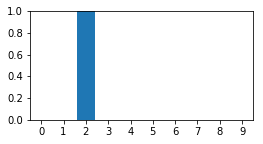

In [8]:
p_val = sess.run(p, feed_dict={x:[image], keep_prob:1.0})

fig = plt.figure(figsize=(4,2))
pred = p_val[0]
subplot = fig.add_subplot(1,1,1)
subplot.set_xticks(range(10))
subplot.set_xlim(-0.5,9.5)
subplot.set_ylim(0,1)
subplot.bar(range(10), pred, align='center')

**[HWR-09]** 1段目のフィルターを適用した画像を表示します。

ここでは、小さなピクセル値をカットする前と後のそれぞれの画像を表示します。

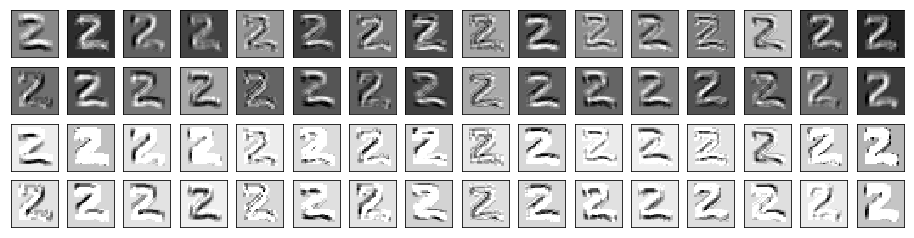

In [9]:
conv1_vals, cutoff1_vals = sess.run(
    [h_conv1, h_conv1_cutoff], feed_dict={x:[image], keep_prob:1.0})

fig = plt.figure(figsize=(16,4))

for f in range(num_filters1):
    subplot = fig.add_subplot(4, 16, f+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv1_vals[0,:,:,f],
                   cmap=plt.cm.gray_r, interpolation='nearest') 

for f in range(num_filters1):
    subplot = fig.add_subplot(4, 16, num_filters1+f+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(cutoff1_vals[0,:,:,f],
                   cmap=plt.cm.gray_r, interpolation='nearest') 

**[HWR-10]** 2段目のフィルターを適用した画像を表示します。

ここでは、小さなピクセル値をカットする前と後のそれぞれの画像を表示します。

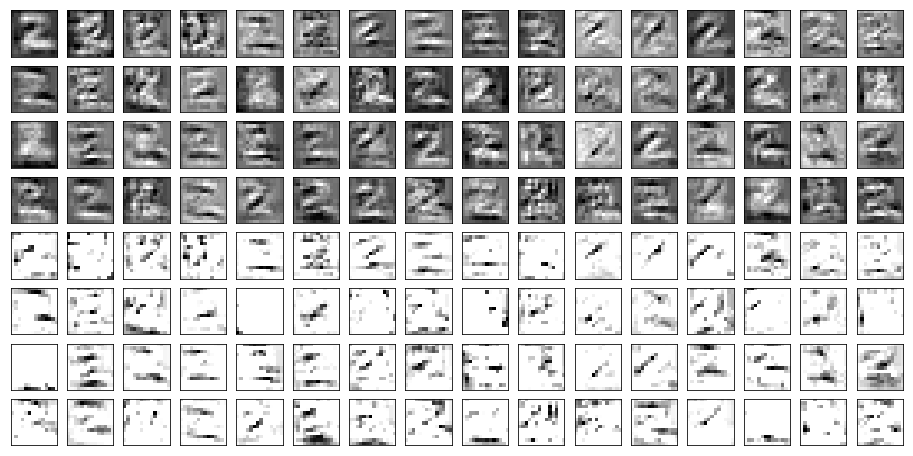

In [10]:
conv2_vals, cutoff2_vals = sess.run(
    [h_conv2, h_conv2_cutoff], feed_dict={x:[image], keep_prob:1.0})

fig = plt.figure(figsize=(16,8))

for f in range(num_filters2):
    subplot = fig.add_subplot(8, 16, f+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv2_vals[0,:,:,f],
                   cmap=plt.cm.gray_r, interpolation='nearest') 

for f in range(num_filters2):
    subplot = fig.add_subplot(8, 16, num_filters2+f+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(cutoff2_vals[0,:,:,f],
                   cmap=plt.cm.gray_r, interpolation='nearest') 